In [1]:
import numpy as np
import la_forge.core as co
import pickle, json, copy
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
from enterprise import constants as const

from enterprise_extensions.chromatic import chromatic
from enterprise_extensions.frequentist.optimal_statistic import OptimalStatistic as OS

You'll need sksparse for get_coefficients() with common signals!


In [2]:
pkl = '/Users/hazboun/ipta/ipta_dr2_classic_de436.pkl'
with open(pkl,'rb')as fin:
    psrs = pickle.load(fin)

In [4]:
rm_idxs = []
for idx, p in enumerate(psrs):
    first = p.toas.min()
    last = p.toas.max()
    tspan = (last - first)/(365.25*24*3600)
    if tspan<3.0:
        rm_idxs.append(idx)
#     print(p.name, f'{tspan:2.1f}')

for idx in reversed(rm_idxs):
    del psrs[idx]

In [5]:
tmin = np.amin([p.toas.min() for p in psrs])
tmax = np.amax([p.toas.max() for p in psrs])
Tspan = tmax - tmin
Tspan/(365.25*24*3600)

30.190711132332584

In [6]:
# Red noise parameter priors
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

# DM Red noise parameter priors
dm_log10_A = parameter.Uniform(-20, -11)
dm_gamma = parameter.Uniform(0, 7)

# GW parameter priors
gw_log10_A = parameter.Uniform(-18, -14)('gw_log10_A')
gw_gamma = parameter.Constant(13./3)('gw_gamma')

# White noise parameter priors
efac = parameter.Constant()
equad = parameter.Constant()
ecorr = parameter.Constant()

freqs = np.linspace(1/Tspan,30/Tspan,30)

In [7]:
# # white noise
selection_ng = selections.Selection(selections.nanograv_backends)
selection_be = selections.Selection(selections.by_backend)

ef = white_signals.MeasurementNoise(efac=efac, selection=selection_be)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection_be)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection_ng)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, modes=freqs)#components=30,Tspan=Tspan)

# DM red noise (powerlaw with 30 frequencies)
dm_basis = utils.createfourierdesignmatrix_dm(modes=freqs)
dm_pl = utils.powerlaw(log10_A=dm_log10_A, gamma=dm_gamma)
dm_gp = gp_signals.BasisGP(priorFunction=dm_pl, basisFunction=dm_basis, name='dm_gp')#components=30,Tspan=Tspan)

# gw (powerlaw with 10 frequencies)

gw_pl = utils.powerlaw(log10_A=gw_log10_A, gamma=gw_gamma)
gw = gp_signals.FourierBasisGP(spectrum=gw_pl, modes=freqs[:10], name='gw')#components=5, Tspan=Tspan, name='gw')

# timing model
tm = gp_signals.TimingModel()

In [8]:
model = tm + ef + eq + rn + dm_gp + gw 
model_ng = model + ec 

In [ ]:
#J1713+0747 DM Dip
pnames = [p.name for p in psrs]

dm_dip = chromatic.dm_exponential_dip(tmin=48850.027042152935, tmax=57051.955677141625)
dip_model = model_ng + dm_dip
J1713 = dip_model(psrs[pnames.index('J1713+0747')])
models[pnames.index('J1713+0747')] = J1713

In [9]:
models = [model_ng(p) if 'NANOGrav' in p.flags['pta'] else model(p) for p in psrs]

In [10]:
pta = signal_base.PTA(models)

In [11]:
noise_path = '/Users/hazboun/ipta/classic_fixed/dr2_classic_noise.json'

In [12]:
with open(noise_path,'r') as fin:
    noise = json.load(fin)

In [13]:
pta.set_default_params(noise)

INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_efac to 1.1365193945368486
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_efac to 0.9799469185765327
INFO: enterprise.signals.signal_base: Setting J0030+0451_EFF.EBPP.1360_efac to 1.1131774722050722
INFO: enterprise.signals.signal_base: Setting J0030+0451_EFF.EBPP.1410_efac to 0.7317297647944114
INFO: enterprise.signals.signal_base: Setting J0030+0451_EFF.EBPP.2639_efac to 0.9816169162003063
INFO: enterprise.signals.signal_base: Setting J0030+0451_JBO.DFB.1520_efac to 1.0323718949754754
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_efac to 1.1237984445609916
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_PUPPI_efac to 1.1395353301435847
INFO: enterprise.signals.signal_base: Setting J0030+0451_NRT.BON.1400_efac to 1.1918353704710902
INFO: enterprise.signals.signal_base: Setting J0030+0451_NRT.BON.1600_efac to 1.5756952974884049
INFO: enterprise.signals.signal_base:

INFO: enterprise.signals.signal_base: Setting J0437-4715_PDFB_40CM_log10_equad to -7.503948141950352
INFO: enterprise.signals.signal_base: Setting J0437-4715_PDFB_50CM_log10_equad to -6.597137744772705
INFO: enterprise.signals.signal_base: Setting J0437-4715_PKS.cpsr1.20cm_legacy_log10_equad to -6.956485100190424
INFO: enterprise.signals.signal_base: Setting J0437-4715_PKS.cpsr2.20cm_legacy_log10_equad to -8.023662046871959
INFO: enterprise.signals.signal_base: Setting J0437-4715_PKS.fptm.20cm-legacy_log10_equad to -6.425095378224767
INFO: enterprise.signals.signal_base: Setting J0437-4715_PKS.s2.20cm-legacy_log10_equad to -7.037802919641953
INFO: enterprise.signals.signal_base: Setting J0437-4715_WBCORR_10CM_log10_equad to -6.416938872758119
INFO: enterprise.signals.signal_base: Setting J0437-4715_WBCORR_20CM_log10_equad to -7.352602899412229
INFO: enterprise.signals.signal_base: Setting J0610-2100_JBO.DFB.1520_efac to 0.9561319405297859
INFO: enterprise.signals.signal_base: Setting J

INFO: enterprise.signals.signal_base: Setting J0621+1002_WSRT.P1.323.C_efac to 2.0634563476909142
INFO: enterprise.signals.signal_base: Setting J0621+1002_WSRT.P1.367.C_efac to 1.60570617347227
INFO: enterprise.signals.signal_base: Setting J0621+1002_EFF.EBPP.1360_log10_equad to -6.840229027469453
INFO: enterprise.signals.signal_base: Setting J0621+1002_EFF.EBPP.1410_log10_equad to -6.4136234859371495
INFO: enterprise.signals.signal_base: Setting J0621+1002_EFF.EBPP.2639_log10_equad to -6.741095969763628
INFO: enterprise.signals.signal_base: Setting J0621+1002_JBO.DFB.1400_log10_equad to -6.523470787480318
INFO: enterprise.signals.signal_base: Setting J0621+1002_JBO.DFB.1520_log10_equad to -7.046538643744288
INFO: enterprise.signals.signal_base: Setting J0621+1002_NRT.BON.1400_log10_equad to -7.084852706049046
INFO: enterprise.signals.signal_base: Setting J0621+1002_NRT.BON.1600_log10_equad to -6.789299166376719
INFO: enterprise.signals.signal_base: Setting J0621+1002_NRT.BON.2000_log1

INFO: enterprise.signals.signal_base: Setting J1012+5307_EFF.EBPP.2639_log10_equad to -7.1968778908834246
INFO: enterprise.signals.signal_base: Setting J1012+5307_JBO.DFB.1400_log10_equad to -7.31409009426702
INFO: enterprise.signals.signal_base: Setting J1012+5307_JBO.DFB.1520_log10_equad to -6.072720916928635
INFO: enterprise.signals.signal_base: Setting J1012+5307_NRT.BON.1400_log10_equad to -6.433160064221364
INFO: enterprise.signals.signal_base: Setting J1012+5307_NRT.BON.1600_log10_equad to -6.023914215850753
INFO: enterprise.signals.signal_base: Setting J1012+5307_NRT.BON.2000_log10_equad to -7.028164319799292
INFO: enterprise.signals.signal_base: Setting J1012+5307_Rcvr1_2_GASP_log10_equad to -7.420332253841796
INFO: enterprise.signals.signal_base: Setting J1012+5307_Rcvr1_2_GUPPI_log10_equad to -6.404566251351747
INFO: enterprise.signals.signal_base: Setting J1012+5307_Rcvr_800_GASP_log10_equad to -7.112374879793455
INFO: enterprise.signals.signal_base: Setting J1012+5307_Rcvr

INFO: enterprise.signals.signal_base: Setting J1024-0719_EFF.EBPP.2639_log10_equad to -6.830146063004504
INFO: enterprise.signals.signal_base: Setting J1024-0719_JBO.DFB.1400_log10_equad to -7.185930655361004
INFO: enterprise.signals.signal_base: Setting J1024-0719_JBO.DFB.1520_log10_equad to -7.284536848244275
INFO: enterprise.signals.signal_base: Setting J1024-0719_NRT.BON.1400_log10_equad to -7.517672194464818
INFO: enterprise.signals.signal_base: Setting J1024-0719_NRT.BON.1600_log10_equad to -6.019849933649348
INFO: enterprise.signals.signal_base: Setting J1024-0719_NRT.BON.2000_log10_equad to -6.742283245955423
INFO: enterprise.signals.signal_base: Setting J1024-0719_PDFB_10CM_log10_equad to -6.211439208875985
INFO: enterprise.signals.signal_base: Setting J1024-0719_PDFB_20CM_log10_equad to -7.488327749842836
INFO: enterprise.signals.signal_base: Setting J1024-0719_PDFB_40CM_log10_equad to -7.387638680458611
INFO: enterprise.signals.signal_base: Setting J1024-0719_PKS.AFB.20cm_le

INFO: enterprise.signals.signal_base: Setting J1600-3053_CPSR2_50CM_log10_equad to -6.8712723879603255
INFO: enterprise.signals.signal_base: Setting J1600-3053_JBO.DFB.1520_log10_equad to -7.398181119937567
INFO: enterprise.signals.signal_base: Setting J1600-3053_NRT.BON.1400_log10_equad to -7.736119597740007
INFO: enterprise.signals.signal_base: Setting J1600-3053_NRT.BON.1600_log10_equad to -7.450061145742775
INFO: enterprise.signals.signal_base: Setting J1600-3053_NRT.BON.2000_log10_equad to -7.369477917696796
INFO: enterprise.signals.signal_base: Setting J1600-3053_PDFB_10CM_log10_equad to -6.493686179607709
INFO: enterprise.signals.signal_base: Setting J1600-3053_PDFB_20CM_log10_equad to -7.622415096598089
INFO: enterprise.signals.signal_base: Setting J1600-3053_PDFB_40CM_log10_equad to -7.181179903982931
INFO: enterprise.signals.signal_base: Setting J1600-3053_PKS.AFB.20cm_legacy_log10_equad to -6.766880071785828
INFO: enterprise.signals.signal_base: Setting J1600-3053_PKS.cpsr2.

INFO: enterprise.signals.signal_base: Setting J1643-1224_CPSR2_50CM_efac to 1.3917000935025994
INFO: enterprise.signals.signal_base: Setting J1643-1224_EFF.EBPP.1360_efac to 1.122987773626916
INFO: enterprise.signals.signal_base: Setting J1643-1224_EFF.EBPP.1410_efac to 1.1937000433597678
INFO: enterprise.signals.signal_base: Setting J1643-1224_EFF.EBPP.2639_efac to 1.3109054407063507
INFO: enterprise.signals.signal_base: Setting J1643-1224_JBO.DFB.1400_efac to 0.9578585891117578
INFO: enterprise.signals.signal_base: Setting J1643-1224_JBO.DFB.1520_efac to 1.0084793120356768
INFO: enterprise.signals.signal_base: Setting J1643-1224_NRT.BON.1400_efac to 1.5761853193020579
INFO: enterprise.signals.signal_base: Setting J1643-1224_NRT.BON.1600_efac to 1.3655377541056362
INFO: enterprise.signals.signal_base: Setting J1643-1224_NRT.BON.2000_efac to 1.2235013328589914
INFO: enterprise.signals.signal_base: Setting J1643-1224_PDFB_10CM_efac to 1.164591315568989
INFO: enterprise.signals.signal_ba

INFO: enterprise.signals.signal_base: Setting J1730-2304_EFF.EBPP.2639_log10_equad to -6.720439918092484
INFO: enterprise.signals.signal_base: Setting J1730-2304_JBO.DFB.1400_log10_equad to -6.588991251865204
INFO: enterprise.signals.signal_base: Setting J1730-2304_JBO.DFB.1520_log10_equad to -7.222693037454217
INFO: enterprise.signals.signal_base: Setting J1730-2304_NRT.BON.1400_log10_equad to -5.876955717865271
INFO: enterprise.signals.signal_base: Setting J1730-2304_NRT.BON.1600_log10_equad to -6.831540723154401
INFO: enterprise.signals.signal_base: Setting J1730-2304_NRT.BON.2000_log10_equad to -7.001844759932361
INFO: enterprise.signals.signal_base: Setting J1730-2304_PDFB_10CM_log10_equad to -7.026162878873915
INFO: enterprise.signals.signal_base: Setting J1730-2304_PDFB_20CM_log10_equad to -6.485617589925986
INFO: enterprise.signals.signal_base: Setting J1730-2304_PDFB_40CM_log10_equad to -7.203619399455408
INFO: enterprise.signals.signal_base: Setting J1730-2304_PKS.AFB.20cm_le

INFO: enterprise.signals.signal_base: Setting J1843-1113_WSRT.P1.1380_efac to 1.116855639902787
INFO: enterprise.signals.signal_base: Setting J1843-1113_WSRT.P1.1380.C_efac to 1.281649221698678
INFO: enterprise.signals.signal_base: Setting J1843-1113_JBO.DFB.1520_log10_equad to -5.222199931083017
INFO: enterprise.signals.signal_base: Setting J1843-1113_NRT.BON.1400_log10_equad to -7.320548713228348
INFO: enterprise.signals.signal_base: Setting J1843-1113_NRT.BON.1600_log10_equad to -7.142903948290848
INFO: enterprise.signals.signal_base: Setting J1843-1113_WSRT.P1.1380_log10_equad to -6.906362600933003
INFO: enterprise.signals.signal_base: Setting J1843-1113_WSRT.P1.1380.C_log10_equad to -6.827547447390401
INFO: enterprise.signals.signal_base: Setting J1853+1303_430_ASP_efac to 1.0720657812672434
INFO: enterprise.signals.signal_base: Setting J1853+1303_430_PUPPI_efac to 1.0678006970906606
INFO: enterprise.signals.signal_base: Setting J1853+1303_JBO.DFB.1520_efac to 1.0933982614166935
I

INFO: enterprise.signals.signal_base: Setting J1903+0327_L-wide_PUPPI_log10_ecorr to -5.957132167196923
INFO: enterprise.signals.signal_base: Setting J1903+0327_S-wide_ASP_log10_ecorr to -7.357913918666095
INFO: enterprise.signals.signal_base: Setting J1903+0327_S-wide_PUPPI_log10_ecorr to -7.19015845306828
INFO: enterprise.signals.signal_base: Setting J1909-3744_CPSR2_20CM_efac to 0.9957694403538463
INFO: enterprise.signals.signal_base: Setting J1909-3744_CPSR2_50CM_efac to 1.1219723851434589
INFO: enterprise.signals.signal_base: Setting J1909-3744_NRT.BON.1400_efac to 1.1798333674951174
INFO: enterprise.signals.signal_base: Setting J1909-3744_NRT.BON.1600_efac to 1.023265703025794
INFO: enterprise.signals.signal_base: Setting J1909-3744_NRT.BON.2000_efac to 1.1861310772650082
INFO: enterprise.signals.signal_base: Setting J1909-3744_PDFB_10CM_efac to 1.0948260186416898
INFO: enterprise.signals.signal_base: Setting J1909-3744_PDFB_20CM_efac to 1.2463951407243932
INFO: enterprise.signal

INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr1_2_GUPPI_log10_equad to -7.407176956710728
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr_800_GASP_log10_equad to -6.88473127071273
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr_800_GUPPI_log10_equad to -7.5859732528755695
INFO: enterprise.signals.signal_base: Setting J1918-0642_WSRT.P1.1380_log10_equad to -7.317444681228515
INFO: enterprise.signals.signal_base: Setting J1918-0642_WSRT.P1.1380.C_log10_equad to -7.033965106496656
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr1_2_GASP_log10_ecorr to -7.616785156591428
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr1_2_GUPPI_log10_ecorr to -6.708765011241715
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr_800_GASP_log10_ecorr to -6.566467342213459
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr_800_GUPPI_log10_ecorr to -7.00434283286094
INFO: enterprise.signals.signal_base: Setting J1939+213

INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_PUPPI_efac to 1.3946160316471428
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_ASP_log10_equad to -7.157736975311375
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_PUPPI_log10_equad to -7.343291894241638
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_ASP_log10_equad to -7.287869228537538
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_PUPPI_log10_equad to -7.610918773791346
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_ASP_log10_ecorr to -6.195910697657067
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_PUPPI_log10_ecorr to -5.890083585252788
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_ASP_log10_ecorr to -6.121101387654186
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_PUPPI_log10_ecorr to -7.059991831987994
INFO: enterprise.signals.signal_base: Setting J1955+2908_430_ASP_efac to 1.07118348297275
I

INFO: enterprise.signals.signal_base: Setting J2124-3358_JBO.DFB.1400_log10_equad to -6.791797019607793
INFO: enterprise.signals.signal_base: Setting J2124-3358_JBO.DFB.1520_log10_equad to -6.6953406173648755
INFO: enterprise.signals.signal_base: Setting J2124-3358_NRT.BON.1400_log10_equad to -7.2437178075168
INFO: enterprise.signals.signal_base: Setting J2124-3358_NRT.BON.1600_log10_equad to -7.192639108571274
INFO: enterprise.signals.signal_base: Setting J2124-3358_NRT.BON.2000_log10_equad to -5.6955248904667375
INFO: enterprise.signals.signal_base: Setting J2124-3358_PDFB_10CM_log10_equad to -6.897402081072292
INFO: enterprise.signals.signal_base: Setting J2124-3358_PDFB_20CM_log10_equad to -7.408710234501136
INFO: enterprise.signals.signal_base: Setting J2124-3358_PDFB_40CM_log10_equad to -7.279849078800557
INFO: enterprise.signals.signal_base: Setting J2124-3358_PKS.AFB.20cm_legacy_log10_equad to -6.802582032065463
INFO: enterprise.signals.signal_base: Setting J2124-3358_PKS.cpsr2

INFO: enterprise.signals.signal_base: Setting J2145-0750_WSRT.P1.323.C_log10_equad to -6.624669363296452
INFO: enterprise.signals.signal_base: Setting J2145-0750_WSRT.P1.367.C_log10_equad to -5.3435965806883345
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr1_2_GASP_log10_ecorr to -5.7393856426104275
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr1_2_GUPPI_log10_ecorr to -6.398455780034647
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr_800_GASP_log10_ecorr to -5.754307689238351
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr_800_GUPPI_log10_ecorr to -5.8343604630483
INFO: enterprise.signals.signal_base: Setting J2229+2643_EFF.EBPP.1360_efac to 1.4703916737364333
INFO: enterprise.signals.signal_base: Setting J2229+2643_EFF.EBPP.2639_efac to 0.49912917841235305
INFO: enterprise.signals.signal_base: Setting J2229+2643_JBO.DFB.1400_efac to 2.066888105331528
INFO: enterprise.signals.signal_base: Setting J2229+2643_JBO.DFB.1520_efac to

## Optimal Statistic

In [14]:
os = OS(psrs=psrs,pta=pta,orf='hd')

In [16]:
chain = np.loadtxt('/Users/hazboun/ipta/classic/model2a_vs_3a/10freqs/fixed_gamma/chain_1.0.txt')
pars = np.loadtxt('/Users/hazboun/ipta/classic/model2a_vs_3a/10freqs/fixed_gamma/pars.txt',dtype=str)

In [17]:
burn = int(0.25*chain.shape[0])
burn

12125

In [18]:
N = 100
Ahat = np.zeros(N)
snr = np.zeros(N)
for ii in range(N):
    param_dict = {}
    idx = np.random.randint(burn,chain.shape[0])
    param_dict = dict(zip(pars,chain[idx,:-4]))
    _, _, _, Asqr, Sigma = os.compute_os(params=param_dict)
    Ahat[ii] = Asqr
    snr[ii] = Asqr/Sigma
    if ii%100 == 0 and ii != 0:
        print(f'\r{ii/10}% complete.',end='',flush=True)

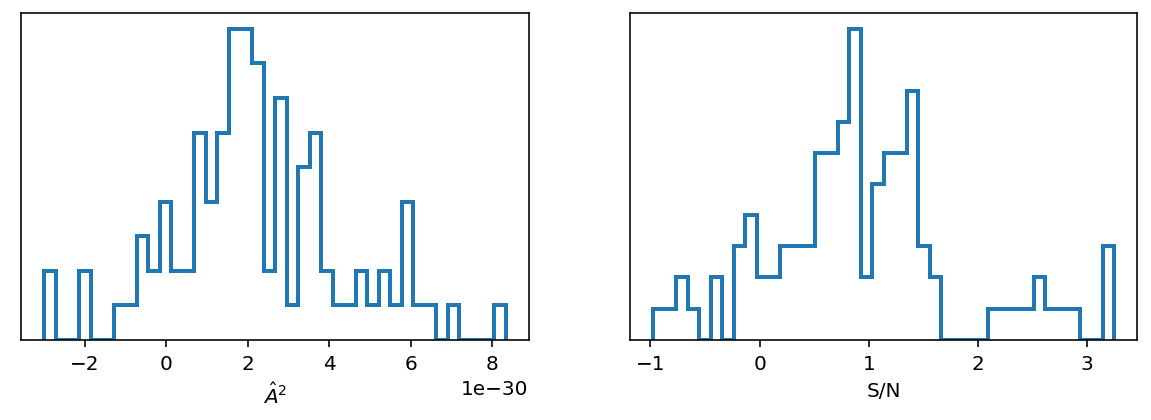

In [19]:
fig = plt.figure(figsize=[10,3])
fig.add_subplot(121)
plt.hist(Ahat,bins=40,histtype='step',lw=2)
plt.yticks([])
plt.xlabel('$\hat{A}^2$')

fig.add_subplot(122)
plt.hist(snr,bins=40,histtype='step',lw=2)
plt.xlabel('S/N')
plt.yticks([])

plt.show()

In [23]:
gw_pshift = gp_signals.FourierBasisGP(spectrum=gw_pl, modes=freqs[:10], name='gw', pshift=True,pseed=1000)
model = tm + ef + eq + rn + dm_gp + gw_pshift 
model_ng = model + ec 

In [24]:
models_pshift = [model_ng(p) if 'NANOGrav' in p.flags['pta'] else model(p) for p in psrs]
pta_pshift = signal_base.PTA(models_pshift)
pta_pshift.set_default_params(noise)

INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_efac to 1.1365193945368486
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_efac to 0.9799469185765327
INFO: enterprise.signals.signal_base: Setting J0030+0451_EFF.EBPP.1360_efac to 1.1131774722050722
INFO: enterprise.signals.signal_base: Setting J0030+0451_EFF.EBPP.1410_efac to 0.7317297647944114
INFO: enterprise.signals.signal_base: Setting J0030+0451_EFF.EBPP.2639_efac to 0.9816169162003063
INFO: enterprise.signals.signal_base: Setting J0030+0451_JBO.DFB.1520_efac to 1.0323718949754754
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_efac to 1.1237984445609916
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_PUPPI_efac to 1.1395353301435847
INFO: enterprise.signals.signal_base: Setting J0030+0451_NRT.BON.1400_efac to 1.1918353704710902
INFO: enterprise.signals.signal_base: Setting J0030+0451_NRT.BON.1600_efac to 1.5756952974884049
INFO: enterprise.signals.signal_base:

INFO: enterprise.signals.signal_base: Setting J0437-4715_PDFB_40CM_log10_equad to -7.503948141950352
INFO: enterprise.signals.signal_base: Setting J0437-4715_PDFB_50CM_log10_equad to -6.597137744772705
INFO: enterprise.signals.signal_base: Setting J0437-4715_PKS.cpsr1.20cm_legacy_log10_equad to -6.956485100190424
INFO: enterprise.signals.signal_base: Setting J0437-4715_PKS.cpsr2.20cm_legacy_log10_equad to -8.023662046871959
INFO: enterprise.signals.signal_base: Setting J0437-4715_PKS.fptm.20cm-legacy_log10_equad to -6.425095378224767
INFO: enterprise.signals.signal_base: Setting J0437-4715_PKS.s2.20cm-legacy_log10_equad to -7.037802919641953
INFO: enterprise.signals.signal_base: Setting J0437-4715_WBCORR_10CM_log10_equad to -6.416938872758119
INFO: enterprise.signals.signal_base: Setting J0437-4715_WBCORR_20CM_log10_equad to -7.352602899412229
INFO: enterprise.signals.signal_base: Setting J0610-2100_JBO.DFB.1520_efac to 0.9561319405297859
INFO: enterprise.signals.signal_base: Setting J

INFO: enterprise.signals.signal_base: Setting J0621+1002_WSRT.P1.323.C_efac to 2.0634563476909142
INFO: enterprise.signals.signal_base: Setting J0621+1002_WSRT.P1.367.C_efac to 1.60570617347227
INFO: enterprise.signals.signal_base: Setting J0621+1002_EFF.EBPP.1360_log10_equad to -6.840229027469453
INFO: enterprise.signals.signal_base: Setting J0621+1002_EFF.EBPP.1410_log10_equad to -6.4136234859371495
INFO: enterprise.signals.signal_base: Setting J0621+1002_EFF.EBPP.2639_log10_equad to -6.741095969763628
INFO: enterprise.signals.signal_base: Setting J0621+1002_JBO.DFB.1400_log10_equad to -6.523470787480318
INFO: enterprise.signals.signal_base: Setting J0621+1002_JBO.DFB.1520_log10_equad to -7.046538643744288
INFO: enterprise.signals.signal_base: Setting J0621+1002_NRT.BON.1400_log10_equad to -7.084852706049046
INFO: enterprise.signals.signal_base: Setting J0621+1002_NRT.BON.1600_log10_equad to -6.789299166376719
INFO: enterprise.signals.signal_base: Setting J0621+1002_NRT.BON.2000_log1

INFO: enterprise.signals.signal_base: Setting J1012+5307_EFF.EBPP.2639_log10_equad to -7.1968778908834246
INFO: enterprise.signals.signal_base: Setting J1012+5307_JBO.DFB.1400_log10_equad to -7.31409009426702
INFO: enterprise.signals.signal_base: Setting J1012+5307_JBO.DFB.1520_log10_equad to -6.072720916928635
INFO: enterprise.signals.signal_base: Setting J1012+5307_NRT.BON.1400_log10_equad to -6.433160064221364
INFO: enterprise.signals.signal_base: Setting J1012+5307_NRT.BON.1600_log10_equad to -6.023914215850753
INFO: enterprise.signals.signal_base: Setting J1012+5307_NRT.BON.2000_log10_equad to -7.028164319799292
INFO: enterprise.signals.signal_base: Setting J1012+5307_Rcvr1_2_GASP_log10_equad to -7.420332253841796
INFO: enterprise.signals.signal_base: Setting J1012+5307_Rcvr1_2_GUPPI_log10_equad to -6.404566251351747
INFO: enterprise.signals.signal_base: Setting J1012+5307_Rcvr_800_GASP_log10_equad to -7.112374879793455
INFO: enterprise.signals.signal_base: Setting J1012+5307_Rcvr

INFO: enterprise.signals.signal_base: Setting J1024-0719_EFF.EBPP.2639_log10_equad to -6.830146063004504
INFO: enterprise.signals.signal_base: Setting J1024-0719_JBO.DFB.1400_log10_equad to -7.185930655361004
INFO: enterprise.signals.signal_base: Setting J1024-0719_JBO.DFB.1520_log10_equad to -7.284536848244275
INFO: enterprise.signals.signal_base: Setting J1024-0719_NRT.BON.1400_log10_equad to -7.517672194464818
INFO: enterprise.signals.signal_base: Setting J1024-0719_NRT.BON.1600_log10_equad to -6.019849933649348
INFO: enterprise.signals.signal_base: Setting J1024-0719_NRT.BON.2000_log10_equad to -6.742283245955423
INFO: enterprise.signals.signal_base: Setting J1024-0719_PDFB_10CM_log10_equad to -6.211439208875985
INFO: enterprise.signals.signal_base: Setting J1024-0719_PDFB_20CM_log10_equad to -7.488327749842836
INFO: enterprise.signals.signal_base: Setting J1024-0719_PDFB_40CM_log10_equad to -7.387638680458611
INFO: enterprise.signals.signal_base: Setting J1024-0719_PKS.AFB.20cm_le

INFO: enterprise.signals.signal_base: Setting J1600-3053_CPSR2_50CM_log10_equad to -6.8712723879603255
INFO: enterprise.signals.signal_base: Setting J1600-3053_JBO.DFB.1520_log10_equad to -7.398181119937567
INFO: enterprise.signals.signal_base: Setting J1600-3053_NRT.BON.1400_log10_equad to -7.736119597740007
INFO: enterprise.signals.signal_base: Setting J1600-3053_NRT.BON.1600_log10_equad to -7.450061145742775
INFO: enterprise.signals.signal_base: Setting J1600-3053_NRT.BON.2000_log10_equad to -7.369477917696796
INFO: enterprise.signals.signal_base: Setting J1600-3053_PDFB_10CM_log10_equad to -6.493686179607709
INFO: enterprise.signals.signal_base: Setting J1600-3053_PDFB_20CM_log10_equad to -7.622415096598089
INFO: enterprise.signals.signal_base: Setting J1600-3053_PDFB_40CM_log10_equad to -7.181179903982931
INFO: enterprise.signals.signal_base: Setting J1600-3053_PKS.AFB.20cm_legacy_log10_equad to -6.766880071785828
INFO: enterprise.signals.signal_base: Setting J1600-3053_PKS.cpsr2.

INFO: enterprise.signals.signal_base: Setting J1643-1224_CPSR2_50CM_efac to 1.3917000935025994
INFO: enterprise.signals.signal_base: Setting J1643-1224_EFF.EBPP.1360_efac to 1.122987773626916
INFO: enterprise.signals.signal_base: Setting J1643-1224_EFF.EBPP.1410_efac to 1.1937000433597678
INFO: enterprise.signals.signal_base: Setting J1643-1224_EFF.EBPP.2639_efac to 1.3109054407063507
INFO: enterprise.signals.signal_base: Setting J1643-1224_JBO.DFB.1400_efac to 0.9578585891117578
INFO: enterprise.signals.signal_base: Setting J1643-1224_JBO.DFB.1520_efac to 1.0084793120356768
INFO: enterprise.signals.signal_base: Setting J1643-1224_NRT.BON.1400_efac to 1.5761853193020579
INFO: enterprise.signals.signal_base: Setting J1643-1224_NRT.BON.1600_efac to 1.3655377541056362
INFO: enterprise.signals.signal_base: Setting J1643-1224_NRT.BON.2000_efac to 1.2235013328589914
INFO: enterprise.signals.signal_base: Setting J1643-1224_PDFB_10CM_efac to 1.164591315568989
INFO: enterprise.signals.signal_ba

INFO: enterprise.signals.signal_base: Setting J1713+0747_WSRT.P1.2273.C_efac to 1.118330976698451
INFO: enterprise.signals.signal_base: Setting J1713+0747_WSRT.P1.840_efac to 0.8658809208608252
INFO: enterprise.signals.signal_base: Setting J1713+0747_WSRT.P1.840.C_efac to 0.9918646768000309
INFO: enterprise.signals.signal_base: Setting J1713+0747_CPSR2_20CM_log10_equad to -6.747656386350427
INFO: enterprise.signals.signal_base: Setting J1713+0747_CPSR2_50CM_log10_equad to -5.8603189030200955
INFO: enterprise.signals.signal_base: Setting J1713+0747_EFF.EBPP.1360_log10_equad to -6.116609001767319
INFO: enterprise.signals.signal_base: Setting J1713+0747_EFF.EBPP.1410_log10_equad to -6.404151630642765
INFO: enterprise.signals.signal_base: Setting J1713+0747_EFF.EBPP.2639_log10_equad to -6.683977263614992
INFO: enterprise.signals.signal_base: Setting J1713+0747_JBO.DFB.1400_log10_equad to -6.05320724633549
INFO: enterprise.signals.signal_base: Setting J1713+0747_JBO.DFB.1520_log10_equad to 

INFO: enterprise.signals.signal_base: Setting J1730-2304_JBO.DFB.1400_log10_equad to -6.588991251865204
INFO: enterprise.signals.signal_base: Setting J1730-2304_JBO.DFB.1520_log10_equad to -7.222693037454217
INFO: enterprise.signals.signal_base: Setting J1730-2304_NRT.BON.1400_log10_equad to -5.876955717865271
INFO: enterprise.signals.signal_base: Setting J1730-2304_NRT.BON.1600_log10_equad to -6.831540723154401
INFO: enterprise.signals.signal_base: Setting J1730-2304_NRT.BON.2000_log10_equad to -7.001844759932361
INFO: enterprise.signals.signal_base: Setting J1730-2304_PDFB_10CM_log10_equad to -7.026162878873915
INFO: enterprise.signals.signal_base: Setting J1730-2304_PDFB_20CM_log10_equad to -6.485617589925986
INFO: enterprise.signals.signal_base: Setting J1730-2304_PDFB_40CM_log10_equad to -7.203619399455408
INFO: enterprise.signals.signal_base: Setting J1730-2304_PKS.AFB.20cm_legacy_log10_equad to -6.8863632914131
INFO: enterprise.signals.signal_base: Setting J1730-2304_PKS.cpsr2.2

INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GUPPI_efac to 1.0475008411750533
INFO: enterprise.signals.signal_base: Setting J1744-1134_WBCORR_10CM_efac to 1.1923717677950219
INFO: enterprise.signals.signal_base: Setting J1744-1134_WBCORR_20CM_efac to 6.457695506403045
INFO: enterprise.signals.signal_base: Setting J1744-1134_WSRT.P1.323.C_efac to 1.0206359420752187
INFO: enterprise.signals.signal_base: Setting J1744-1134_WSRT.P1.367.C_efac to 1.0637271807701387
INFO: enterprise.signals.signal_base: Setting J1744-1134_CPSR2_20CM_log10_equad to -6.201688175926256
INFO: enterprise.signals.signal_base: Setting J1744-1134_CPSR2_50CM_log10_equad to -6.014125001219935
INFO: enterprise.signals.signal_base: Setting J1744-1134_EFF.EBPP.1360_log10_equad to -6.101254115579169
INFO: enterprise.signals.signal_base: Setting J1744-1134_EFF.EBPP.1410_log10_equad to -6.053471015575675
INFO: enterprise.signals.signal_base: Setting J1744-1134_EFF.EBPP.2639_log10_equad to -6.08683699919

INFO: enterprise.signals.signal_base: Setting J1843-1113_JBO.DFB.1520_log10_equad to -5.222199931083017
INFO: enterprise.signals.signal_base: Setting J1843-1113_NRT.BON.1400_log10_equad to -7.320548713228348
INFO: enterprise.signals.signal_base: Setting J1843-1113_NRT.BON.1600_log10_equad to -7.142903948290848
INFO: enterprise.signals.signal_base: Setting J1843-1113_WSRT.P1.1380_log10_equad to -6.906362600933003
INFO: enterprise.signals.signal_base: Setting J1843-1113_WSRT.P1.1380.C_log10_equad to -6.827547447390401
INFO: enterprise.signals.signal_base: Setting J1853+1303_430_ASP_efac to 1.0720657812672434
INFO: enterprise.signals.signal_base: Setting J1853+1303_430_PUPPI_efac to 1.0678006970906606
INFO: enterprise.signals.signal_base: Setting J1853+1303_JBO.DFB.1520_efac to 1.0933982614166935
INFO: enterprise.signals.signal_base: Setting J1853+1303_L-wide_ASP_efac to 1.1400259514809836
INFO: enterprise.signals.signal_base: Setting J1853+1303_L-wide_PUPPI_efac to 1.1554262130391095
INF

INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr_800_GASP_log10_equad to -6.88473127071273
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr_800_GUPPI_log10_equad to -7.5859732528755695
INFO: enterprise.signals.signal_base: Setting J1918-0642_WSRT.P1.1380_log10_equad to -7.317444681228515
INFO: enterprise.signals.signal_base: Setting J1918-0642_WSRT.P1.1380.C_log10_equad to -7.033965106496656
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr1_2_GASP_log10_ecorr to -7.616785156591428
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr1_2_GUPPI_log10_ecorr to -6.708765011241715
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr_800_GASP_log10_ecorr to -6.566467342213459
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr_800_GUPPI_log10_ecorr to -7.00434283286094
INFO: enterprise.signals.signal_base: Setting J1939+2134_CPSR2_20CM_efac to 1.4626346997570936
INFO: enterprise.signals.signal_base: Setting J1939+2134_CPSR2_50

INFO: enterprise.signals.signal_base: Setting J2124-3358_JBO.DFB.1400_log10_equad to -6.791797019607793
INFO: enterprise.signals.signal_base: Setting J2124-3358_JBO.DFB.1520_log10_equad to -6.6953406173648755
INFO: enterprise.signals.signal_base: Setting J2124-3358_NRT.BON.1400_log10_equad to -7.2437178075168
INFO: enterprise.signals.signal_base: Setting J2124-3358_NRT.BON.1600_log10_equad to -7.192639108571274
INFO: enterprise.signals.signal_base: Setting J2124-3358_NRT.BON.2000_log10_equad to -5.6955248904667375
INFO: enterprise.signals.signal_base: Setting J2124-3358_PDFB_10CM_log10_equad to -6.897402081072292
INFO: enterprise.signals.signal_base: Setting J2124-3358_PDFB_20CM_log10_equad to -7.408710234501136
INFO: enterprise.signals.signal_base: Setting J2124-3358_PDFB_40CM_log10_equad to -7.279849078800557
INFO: enterprise.signals.signal_base: Setting J2124-3358_PKS.AFB.20cm_legacy_log10_equad to -6.802582032065463
INFO: enterprise.signals.signal_base: Setting J2124-3358_PKS.cpsr2

INFO: enterprise.signals.signal_base: Setting J2145-0750_WSRT.P1.323.C_log10_equad to -6.624669363296452
INFO: enterprise.signals.signal_base: Setting J2145-0750_WSRT.P1.367.C_log10_equad to -5.3435965806883345
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr1_2_GASP_log10_ecorr to -5.7393856426104275
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr1_2_GUPPI_log10_ecorr to -6.398455780034647
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr_800_GASP_log10_ecorr to -5.754307689238351
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr_800_GUPPI_log10_ecorr to -5.8343604630483
INFO: enterprise.signals.signal_base: Setting J2229+2643_EFF.EBPP.1360_efac to 1.4703916737364333
INFO: enterprise.signals.signal_base: Setting J2229+2643_EFF.EBPP.2639_efac to 0.49912917841235305
INFO: enterprise.signals.signal_base: Setting J2229+2643_JBO.DFB.1400_efac to 2.066888105331528
INFO: enterprise.signals.signal_base: Setting J2229+2643_JBO.DFB.1520_efac to

In [25]:
os_pshift = OS(psrs=psrs,pta=pta_pshift,orf='hd')

In [ ]:
print(pta_pshift.summary())

In [26]:
#Check 
param_dict = {}
idx = 4842
param_dict = dict(zip(pars,chain[idx,:-4]))
_, _, _, Asqr, Sigma = os_pshift.compute_os(params=param_dict)
print(Asqr, Sigma)


ValueError: operands could not be broadcast together with shapes (60,) (80,) 

In [ ]:
N = 100
Ahat_pshift = np.zeros(N)
snr_pshift = np.zeros(N)
for ii in range(N):
    param_dict = {}
    idx = np.random.randint(burn,chain.shape[0])
    param_dict = dict(zip(pars,chain[idx,:-4]))
    _, _, _, Asqr, Sigma = os_pshift.compute_os(params=param_dict)
    Ahat_pshift[ii] = Asqr
    snr_pshift[ii] = Asqr/Sigma
    if ii%100 == 0 and ii != 0:
        print(f'\r{ii/10}% complete.',end='',flush=True)

In [ ]:
pta_pshift._signalcollections[0]._signals[5].signal_name

In [ ]:
fig = plt.figure(figsize=[10,3])
fig.add_subplot(121)
plt.hist(Ahat,bins=40,histtype='step',label='Measured OS',lw=2)
plt.hist(Ahat_pshift,bins=40,histtype='step',labeled='Phase Shifted OS',lw=2)
plt.yticks([])
plt.xlabel('$\hat{A}^2$')
plt.legend()

fig.add_subplot(122)
plt.hist(snr,bins=40,histtype='step',label='Measured S/N',lw=2)
plt.hist(snr_pshift,bins=40,histtype='step',labeled='Phase Shifted S/N',lw=2)
plt.xlabel('S/N')
plt.yticks([])
plt.legend()

plt.show()